In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import random
import os


In [2]:
image =nib.load('RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_00000/BraTS2021_00000_t2.nii.gz').get_fdata()

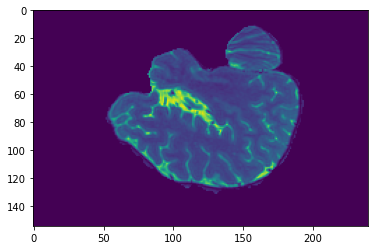

In [12]:
img =image
mid_slice_x = img[80,:,:]
img.shape
plt.imshow(mid_slice_x.T)

In [15]:
class DataLoader:
    def __init__(self,path):
        self.path = path
        
    def get_list_files(self):
        
        return sorted(os.listdir(self.path))
    
    def get_random_images(self,channel,which_chan):
        random_brain_dir = random.choice(self.get_list_files())
        exact_path = self.path + '/' + random_brain_dir

        number_of_image = random_brain_dir[-5:]
        
        image_flair = nib.load(f'{exact_path}/BraTS2021_{number_of_image}_flair.nii.gz').get_fdata()
        image_seg = nib.load(f'{exact_path}/BraTS2021_{number_of_image}_seg.nii.gz').get_fdata()
        image_t1 = nib.load(f'{exact_path}/BraTS2021_{number_of_image}_t1.nii.gz').get_fdata()
        image_t1ce = nib.load(f'{exact_path}/BraTS2021_{number_of_image}_t1ce.nii.gz').get_fdata()
        image_t2 = nib.load(f'{exact_path}/BraTS2021_{number_of_image}_t2.nii.gz').get_fdata()
        
        which_channel =which_chan
        if which_channel == 1:
            mid_slice_flair = image_flair[channel,:,:]
            mid_slice_t1 = image_t1[channel,:,:]
            mid_slice_t1ce = image_t1ce[channel,:,:]
            mid_slice_t2 = image_t2[channel,:,:]
        
        elif which_channel == 2:
            
            mid_slice_flair = image_flair[:,channel,:]
            mid_slice_t1 = image_t1[:,channel,:]
            mid_slice_t1ce = image_t1ce[:,channel,:]
            mid_slice_t2 = image_t2[:,channel,:]
            
            
            
        elif which_channel == 3:
            mid_slice_flair = image_flair[:,:,channel]
            mid_slice_t1 = image_t1[:,:,channel]
            mid_slice_t1ce = image_t1ce[:,:,channel]
            mid_slice_t2 = image_t2[:,:,channel]
            
            
        
        fig,axes = plt.subplots(2, 3, figsize=(30, 25))    

        fig.suptitle(f'Mozg nr {number_of_image}', fontsize=40)
        mid_slice_seg = image_seg[:,:,channel]
        fig.patch.set_facecolor('white')

        axes[0,0].imshow(mid_slice_flair.T,cmap='gray', origin='lower')
        axes[0,0].set_title('Flair')
            
        axes[0,1].imshow(mid_slice_t1.T,cmap='gray', origin='lower')
        axes[0,1].set_title('t1')
            
        axes[0,2].imshow(mid_slice_t1ce.T,cmap='gray', origin='lower')
        axes[0,2].set_title('t1ce')
            
        axes[1,0].imshow(mid_slice_t2.T,cmap='gray', origin='lower')
        axes[1,0].set_title('t2')
            
        axes[1,1].imshow(mid_slice_seg.T,cmap='gray', origin='lower')
        axes[1,1].set_title('t1seg')
            
        axes[1,2].imshow(mid_slice_seg.T, origin='lower')
        axes[1,2].set_title('t1seg')
            
        
  
        

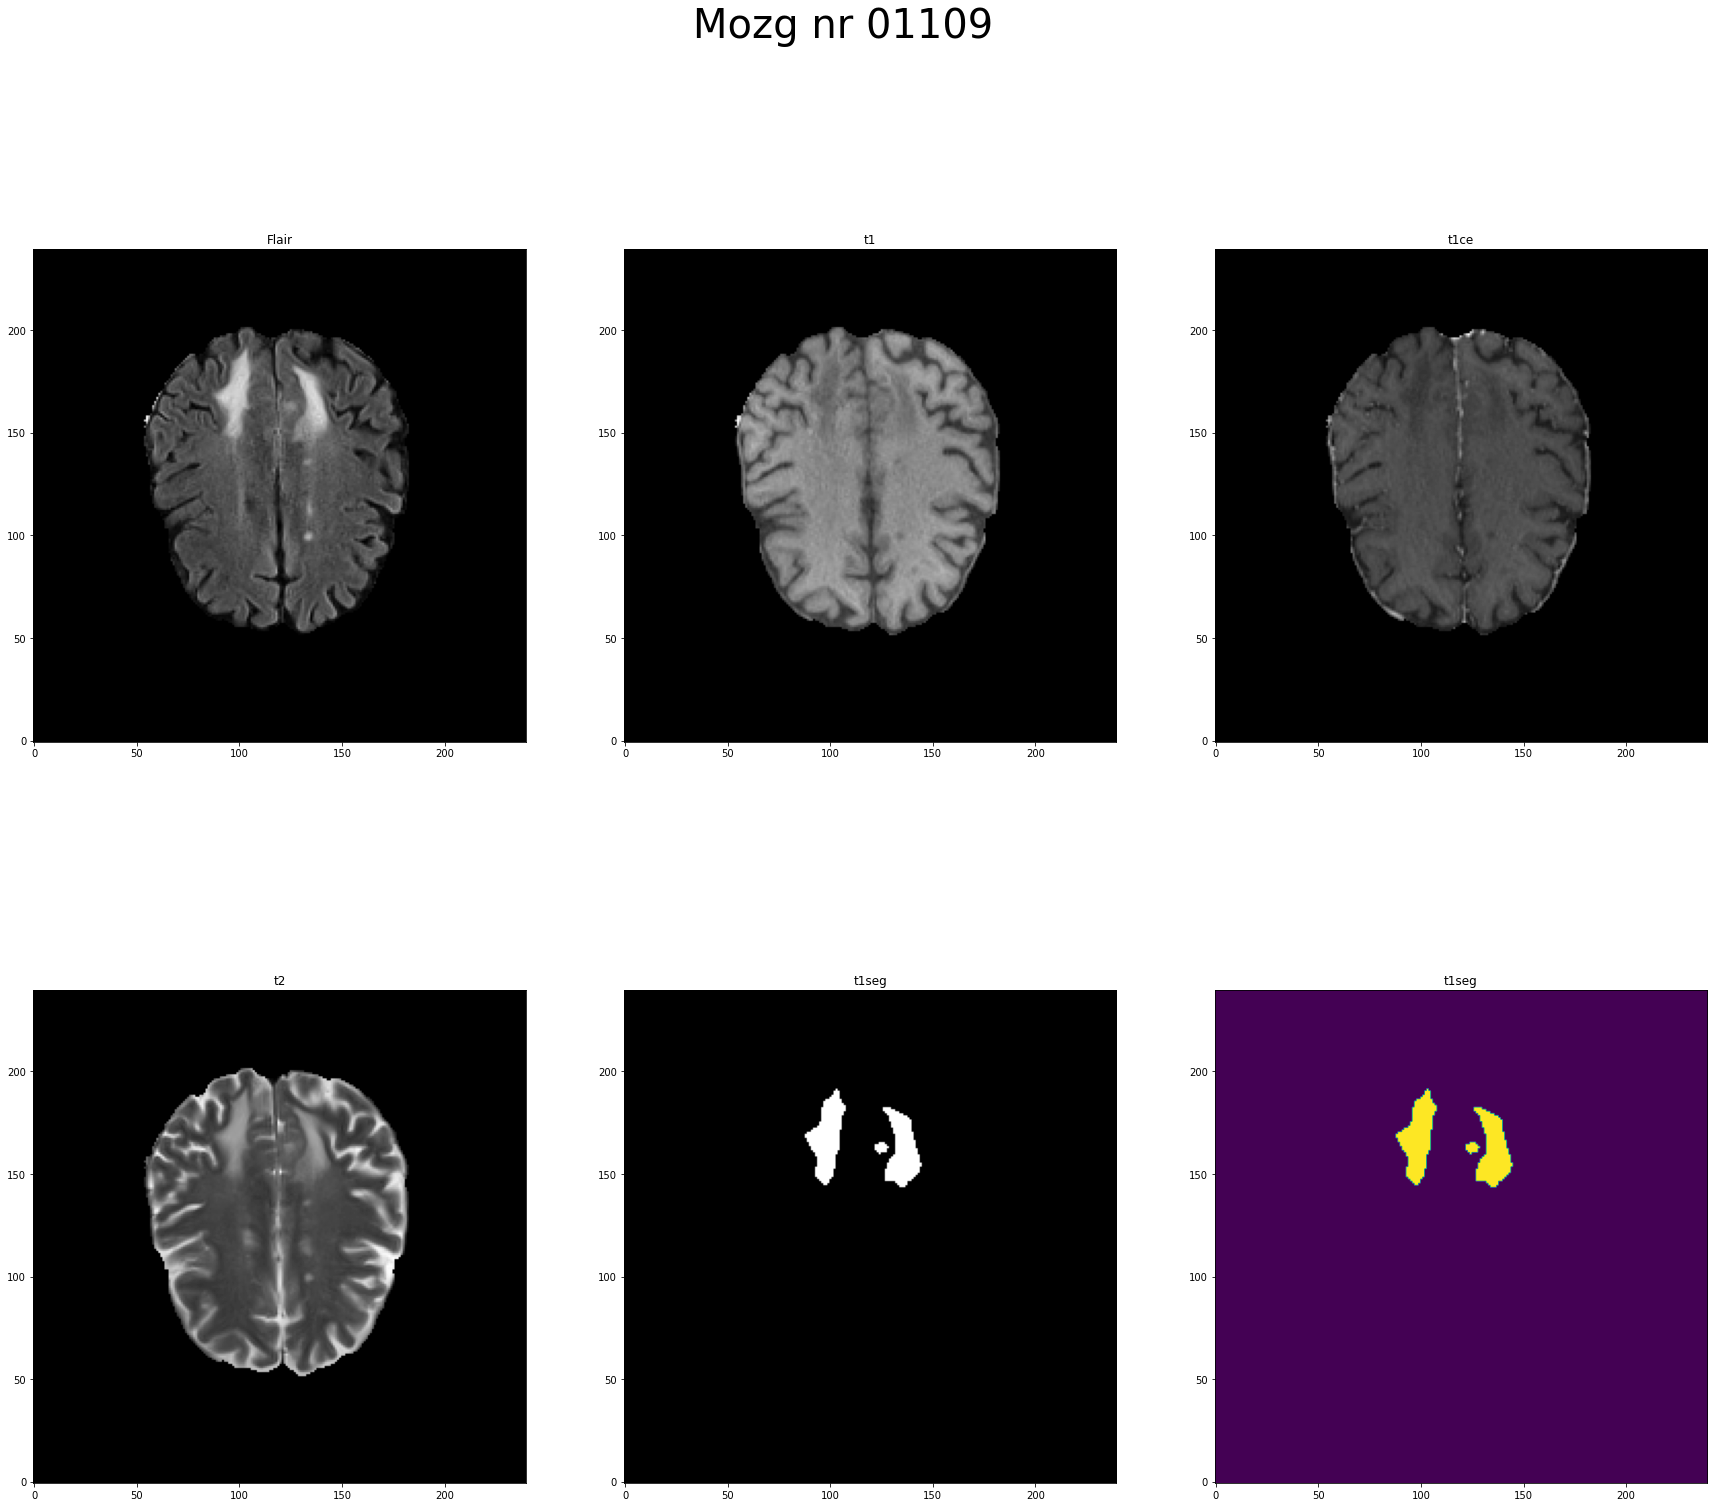

In [30]:
load = DataLoader('RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021')
load.get_random_images(100,3)

In [ ]:

################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=240, IMG_WIDTH=240, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    

    return model
